4

In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [ ]:
!kaggle datasets download -d mojtaba142/hotel-booking

Dataset URL: https://www.kaggle.com/datasets/mojtaba142/hotel-booking
License(s): copyright-authors
hotel-booking.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/hotel-booking.zip

Archive:  /content/hotel-booking.zip
replace hotel_booking.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
#import ing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold,learning_curve
from sklearn.metrics import classification_report, confusion_matrix






In [3]:
df=pd.read_csv('/content/drive/MyDrive/ML_PROJECT/notebook/data/hotel_booking.csv')

#Droping useless dataset with some features


In [4]:
#deleting some unuseful columns
df.drop(['name','email','phone-number','credit_card'],axis=1,inplace=True)

#**Missing value imputation**

In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card'],
      dtype='object')

In [ ]:
#Columns with missing value
ndf=pd.DataFrame(df.isnull().sum(),columns=['Null'])
ndf = ndf.rename_axis('Columns').reset_index()
ndf[ndf['Null']!=0]


,Columns,Null
10,children,4
13,country,488
23,agent,16340
24,company,112593


In [ ]:
#Row where children have missing value
df[df['children'].isnull()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
40600,City Hotel,1,2,2015,August,32,3,1,0,2,...,No Deposit,NaN,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-01
40667,City Hotel,1,1,2015,August,32,5,0,2,2,...,No Deposit,14.0,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-04
40679,City Hotel,1,1,2015,August,32,5,0,2,3,...,No Deposit,NaN,NaN,0,Transient-Party,18.0,0,2,Canceled,2015-08-04
41160,City Hotel,1,8,2015,August,33,13,2,5,2,...,No Deposit,9.0,NaN,0,Transient-Party,76.5,0,1,Canceled,2015-08-09


In [5]:
#Removing agent and company because of incompleteness
df.drop(['agent','company'],axis=1,inplace=True)

In [6]:
df.dropna(inplace=True)

In [ ]:
print("Shape after missing value imputation:-",df.shape)

Shape after missing value imputation:- (118898, 30)


In [7]:
#Drpoing where all memebers are 0
df[(df['adults']==0) & (df['children']==0) & (df['babies']==0)]['is_canceled'].value_counts()
df = df.drop(df[(df['adults']==0) & (df['children']==0) & (df['babies']==0)].index)

In [ ]:
#seperating categorical and numerical data
categ_data=df.select_dtypes(include='object').columns
num_data=df.select_dtypes(exclude='object').columns

In [ ]:
df['reservation_status_date']=pd.to_datetime(df['reservation_status_date'])
df['reservation_status_date']

0        2015-07-01
1        2015-07-01
2        2015-07-02
3        2015-07-02
4        2015-07-03
            ...    
119385   2017-09-06
119386   2017-09-07
119387   2017-09-07
119388   2017-09-07
119389   2017-09-07
Name: reservation_status_date, Length: 118728, dtype: datetime64[ns]

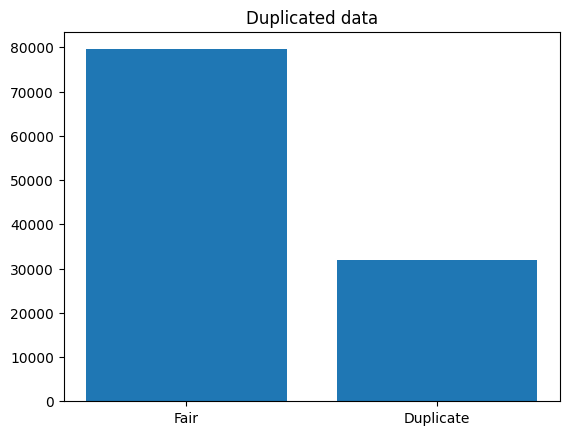

In [ ]:
#Duplicate data found
plt.bar(df.duplicated().value_counts().index,df.duplicated().value_counts().values)
plt.xticks([0,1],['Fair','Duplicate'])
plt.title('Duplicated data')
plt.show()

#**DATA ANALYSIS**

In [ ]:
df.sample(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
94722,City Hotel,0,166,2016,August,32,4,2,3,2,...,A,0,No Deposit,0,Transient,99.45,0,1,Check-Out,2016-08-09
18330,Resort Hotel,0,82,2016,February,7,7,2,0,2,...,A,0,No Deposit,0,Transient-Party,72.00,0,0,Check-Out,2016-02-09
40852,City Hotel,1,124,2015,August,32,8,2,1,2,...,A,0,No Deposit,0,Transient-Party,94.50,0,0,Canceled,2015-08-01
116241,City Hotel,0,94,2017,July,28,14,1,2,2,...,A,0,No Deposit,0,Transient,80.10,0,0,Check-Out,2017-07-17
38956,Resort Hotel,0,97,2017,August,31,1,0,3,2,...,A,0,No Deposit,0,Transient,230.00,0,2,Check-Out,2017-08-04
44389,City Hotel,0,88,2015,October,41,5,1,1,2,...,D,0,No Deposit,77,Transient-Party,112.20,0,0,Check-Out,2015-10-07
33138,Resort Hotel,0,27,2017,February,7,14,0,2,2,...,G,0,No Deposit,0,Transient,95.00,1,1,Check-Out,2017-02-16
94755,City Hotel,0,177,2016,August,32,2,2,5,2,...,A,0,No Deposit,0,Transient,99.45,0,1,Check-Out,2016-08-09
8893,Resort Hotel,1,63,2016,October,43,18,0,4,2,...,D,0,No Deposit,0,Transient,74.00,0,2,Canceled,2016-10-05
5922,Resort Hotel,1,95,2016,May,21,16,1,5,2,...,D,0,No Deposit,0,Transient,79.00,0,0,Canceled,2016-04-04


In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

Check data balance

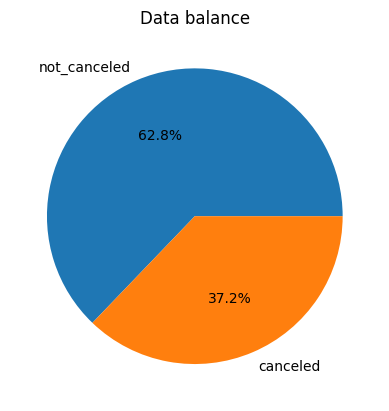

In [8]:
plt.pie(df['is_canceled'].value_counts(),labels=['not_canceled','canceled'],autopct='%1.1f%%')
plt.title('Data balance')
plt.show()

<Axes: xlabel='deposit_type', ylabel='count'>

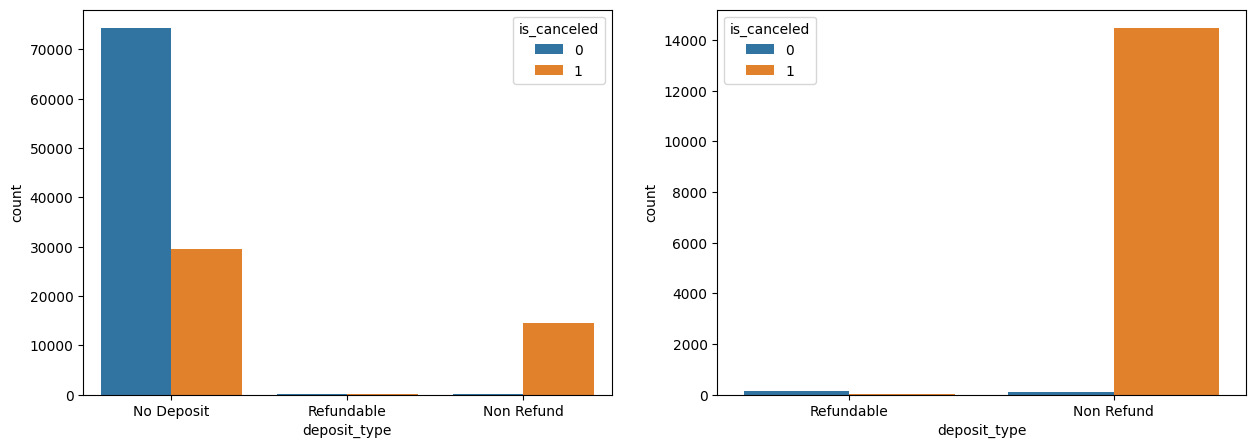

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.countplot(data=df,x='deposit_type',hue='is_canceled')
plt.subplot(122)
sns.countplot(data=df,x=df[df['deposit_type']!='No Deposit']['deposit_type'],hue='is_canceled')

Insights

1.For a non refund deposite type booking cancelation is high.


Text(0.5, 1.0, 'DISTRIBUTION CHANNEL VS BOOKING CANCELATION')

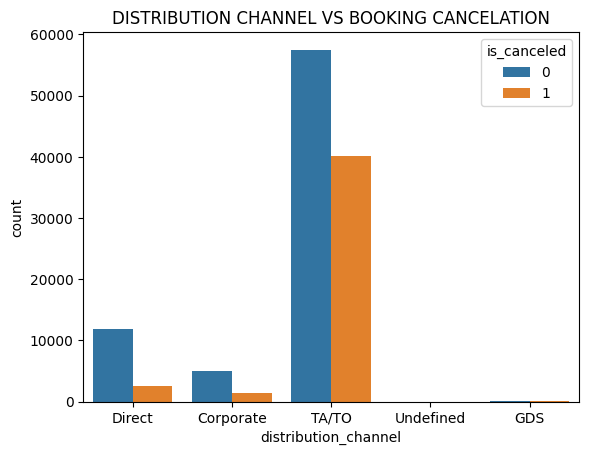

In [ ]:
#Distribution channel and booking cancelation
sns.countplot(data=df,x='distribution_channel',hue='is_canceled')
plt.title("DISTRIBUTION CHANNEL VS BOOKING CANCELATION")

In [ ]:
#droping where distribution channel equal to undefined
df=df[df['distribution_channel']!='Undefined']

Booking cancelation by room type analysis

In [ ]:
rooms=df['reserved_room_type'].unique()

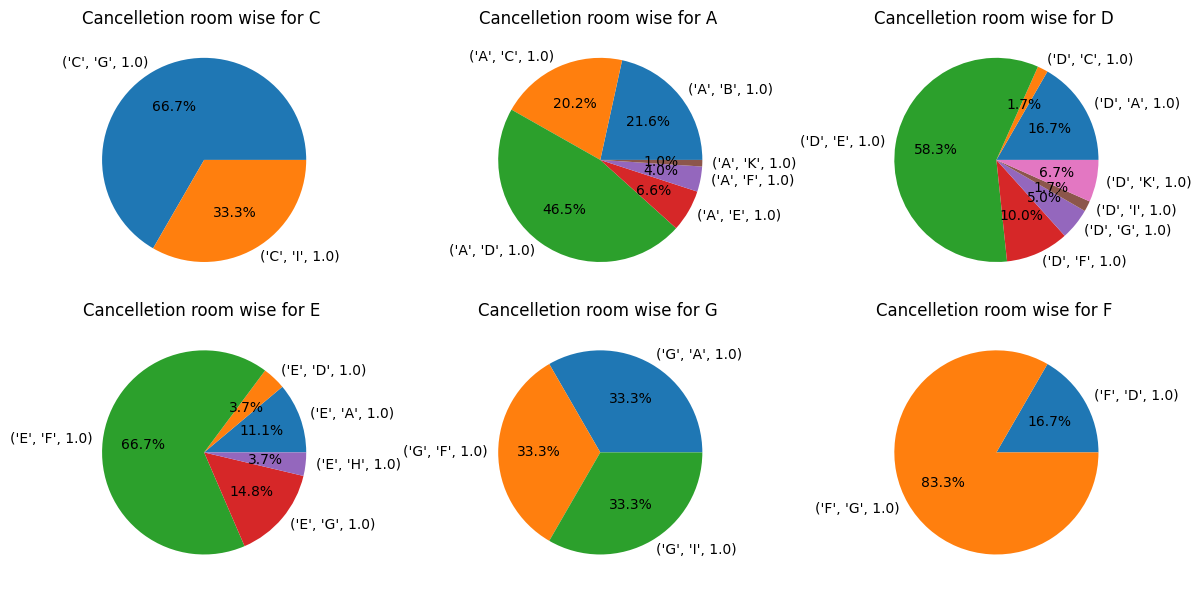

In [ ]:
fig,axes=plt.subplots(2,3,figsize=(12,6))
ax_index=0
for val in rooms:
  if ax_index >=6:
    break
  df_room=df[df['reserved_room_type']==val]
  # Create a boolean mask for rows with different values
  differ = df_room['reserved_room_type'] != df_room['assigned_room_type']

  # Filter the DataFrame using the mask
  filtered_df = df_room[differ]

  label = filtered_df.groupby(['reserved_room_type', 'assigned_room_type',filtered_df[filtered_df['is_canceled']==1]['is_canceled']]).size().index
  values = filtered_df.groupby(['reserved_room_type', 'assigned_room_type',filtered_df[filtered_df['is_canceled']==1]['is_canceled']]).size().values

  # Remove portion which is less than 1%
  filtered_labels = [l for l, v in zip(label, values) if v / sum(values) >= 0.01]
  filtered_values = [v for v in values if v / sum(values) >= 0.01]

  row=ax_index // 3
  col=ax_index % 3
  axes[row,col].pie(filtered_values,labels=filtered_labels,autopct='%1.1f%%')
  axes[row,col].set_title(f'Cancelletion room wise for {val} ')
  ax_index+=1
plt.tight_layout()
plt.show()

Insights

1.Differ in customer reserved room type and assigned room is a major reason for high booking cancelation

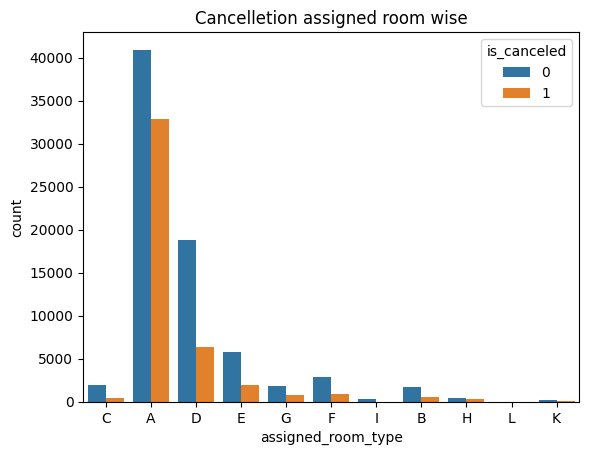

In [ ]:
#Most of cancelation occur in A
sns.countplot(data=df,x='assigned_room_type',hue='is_canceled')
plt.title(f'Cancelletion assigned room wise')
plt.show()

Insights

1.Most of the cancellation occur for assigned room type A

In [ ]:
room_a=df[df['assigned_room_type']=='A']

Text(0.5, 1.0, 'lead_time for room A')

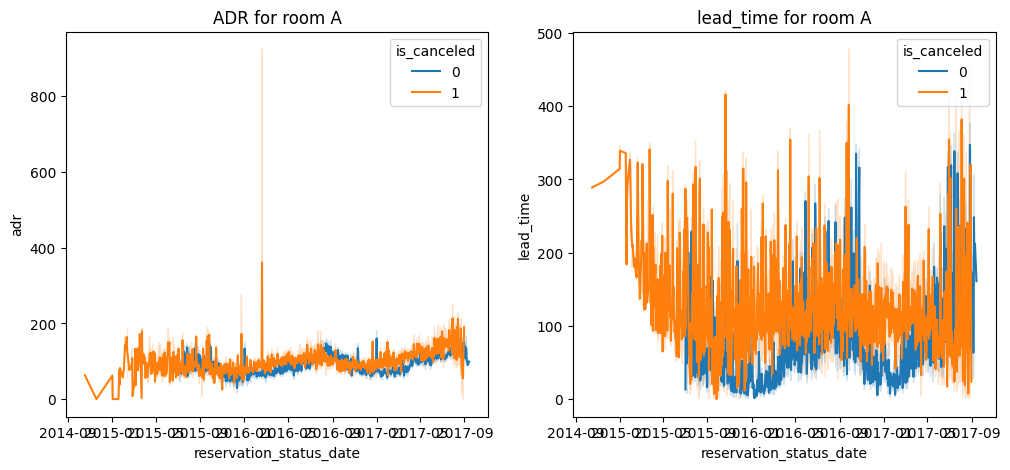

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=room_a,x='reservation_status_date',y='adr',hue='is_canceled')
plt.title('ADR for room A')

plt.subplot(122)
sns.lineplot(data=room_a,x='reservation_status_date',y='lead_time',hue='is_canceled')
plt.title('lead_time for room A')


Insights

Reason for high cancellation in room A is due to increase in  'average daily rate' and 'lead time'

Booking cancelation by changes in demanded request

In [ ]:
prev_cancelation=df[df['previous_cancellations']>1]

In [ ]:
df1=prev_cancelation[prev_cancelation['hotel']=='City Hotel']

Text(0.5, 1.0, 'cancelation rate with parking space required ')

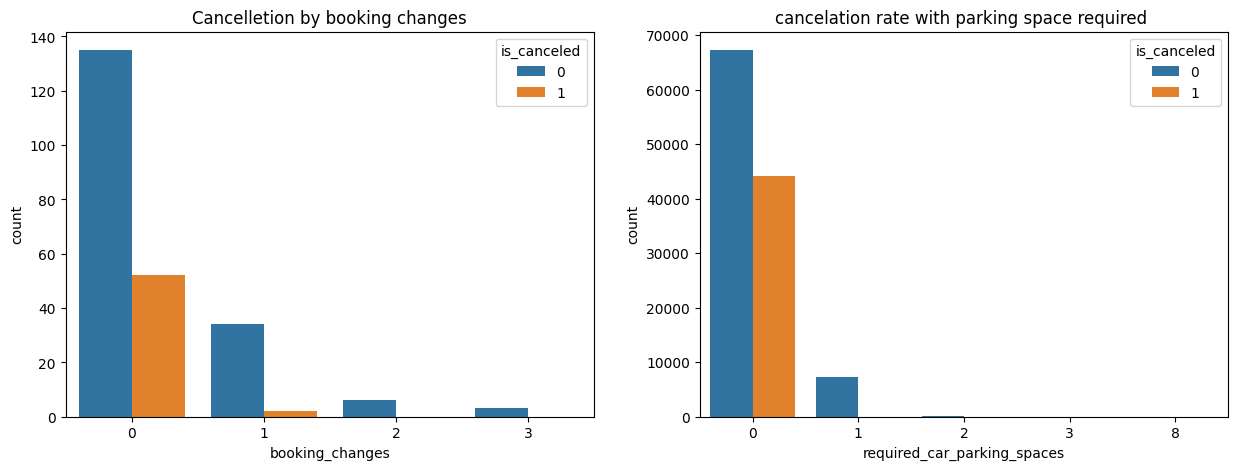

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.countplot(data=df,x='booking_changes',hue='is_canceled')
plt.title('Cancelletion by booking changes')
plt.subplot(122)
sns.countplot(data=df,x='required_car_parking_spaces',hue='is_canceled')
plt.title('cancelation rate with parking space required ')

Insights

1.Booking changes and Car parking space not much affect booking cancelation

In [ ]:
#Keeping only those record for which parking space not required(undersampling)
df=df[df['required_car_parking_spaces']<1]
#Now we have no need of required_car_parking_spaces column
df.drop(['required_car_parking_spaces'],axis=1,inplace=True)

Text(0.5, 1.0, 'Cancelation rate with increase in daily price ')

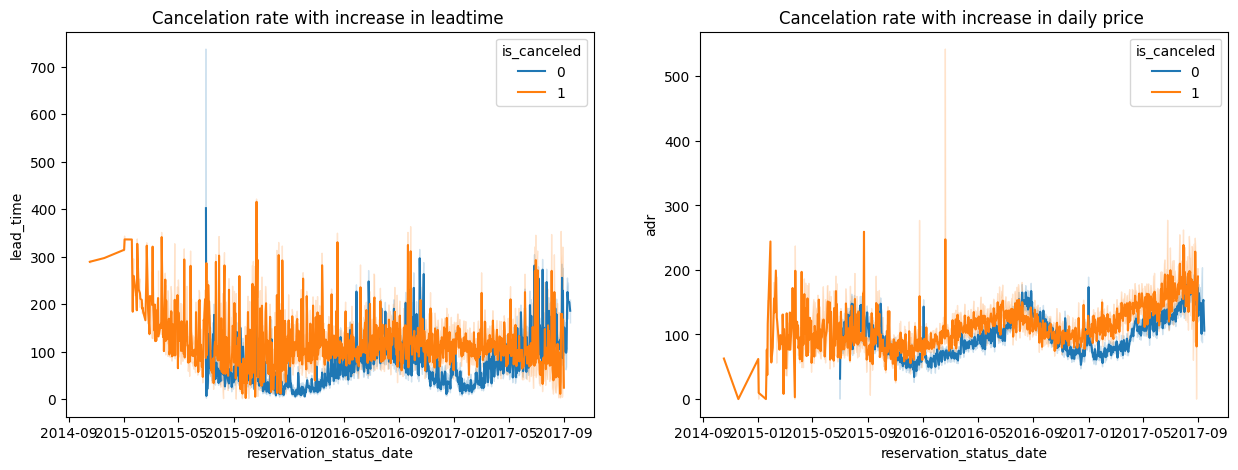

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.lineplot(data=df,x='reservation_status_date',y='lead_time',hue='is_canceled')
plt.title('Cancelation rate with increase in leadtime ')
plt.subplot(122)
sns.lineplot(data=df,x='reservation_status_date',y='adr',hue='is_canceled')
plt.title('Cancelation rate with increase in daily price rate')

<Axes: xlabel='previous_cancellations', ylabel='lead_time'>

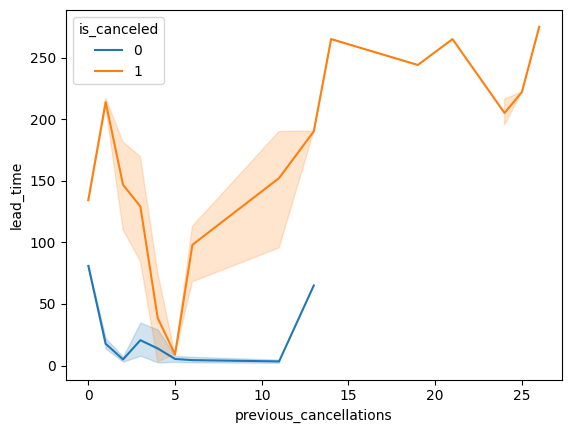

In [ ]:
sns.lineplot(data=df,x='previous_cancellations',y='lead_time',hue='is_canceled')
plt.title("Previous Cancelation rate with increase in leadtime ")
plt.show()

Insights

1.Previously much of cancelation occur due to increase in lead_time

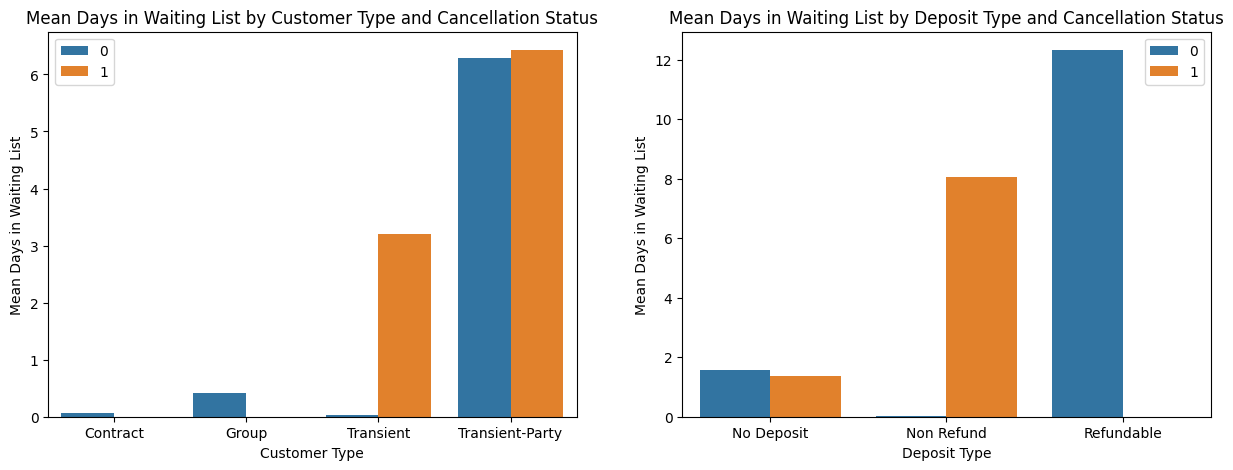

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
grouped_data = df.groupby(['customer_type', 'is_canceled'])['days_in_waiting_list'].mean().reset_index()

#Use Seaborn to create a barplot with hue
sns.barplot(x='customer_type',y='days_in_waiting_list',hue='is_canceled',data=grouped_data)

plt.xlabel('Customer Type')
plt.ylabel('Mean Days in Waiting List')
plt.title('Mean Days in Waiting List by Customer Type and Cancellation Status')
plt.legend()
plt.subplot(122)
grouped_data = df.groupby(['deposit_type', 'is_canceled'])['days_in_waiting_list'].mean().reset_index()

#Use Seaborn to create a barplot with hue
sns.barplot(x='deposit_type',y='days_in_waiting_list',hue='is_canceled',data=grouped_data)

plt.xlabel('Deposit Type')
plt.ylabel('Mean Days in Waiting List')
plt.title('Mean Days in Waiting List by Deposit Type and Cancellation Status')
plt.legend()

Insights(with increase in days of waiting list)

1.Transient-party type customers with deposit type of non refundable play a major role in booking cancellation


#**Data preprocessing**

In [ ]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
count,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727.000000,118727
mean,0.371760,104.401324,2016.157605,27.165093,15.801056,0.928298,2.500914,1.861051,0.104349,0.007959,0.031593,0.087208,0.131613,0.218830,2.330658,102.133353,0.061907,0.571765,2016-07-30 05:56:02.217524224
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,2016-02-02 00:00:00
50%,0.000000,70.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,2016-08-07 00:00:00
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,2017-02-09 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,40.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,391.000000,5400.000000,8.000000,5.000000,2017-09-14 00:00:00
std,0.483277,106.915734,0.707451,13.586419,8.780393,0.992724,1.889096,0.574699,0.399432,0.097450,0.174916,0.846423,1.485306,0.638916,17.633138,50.389804,0.244216,0.792732,NaN


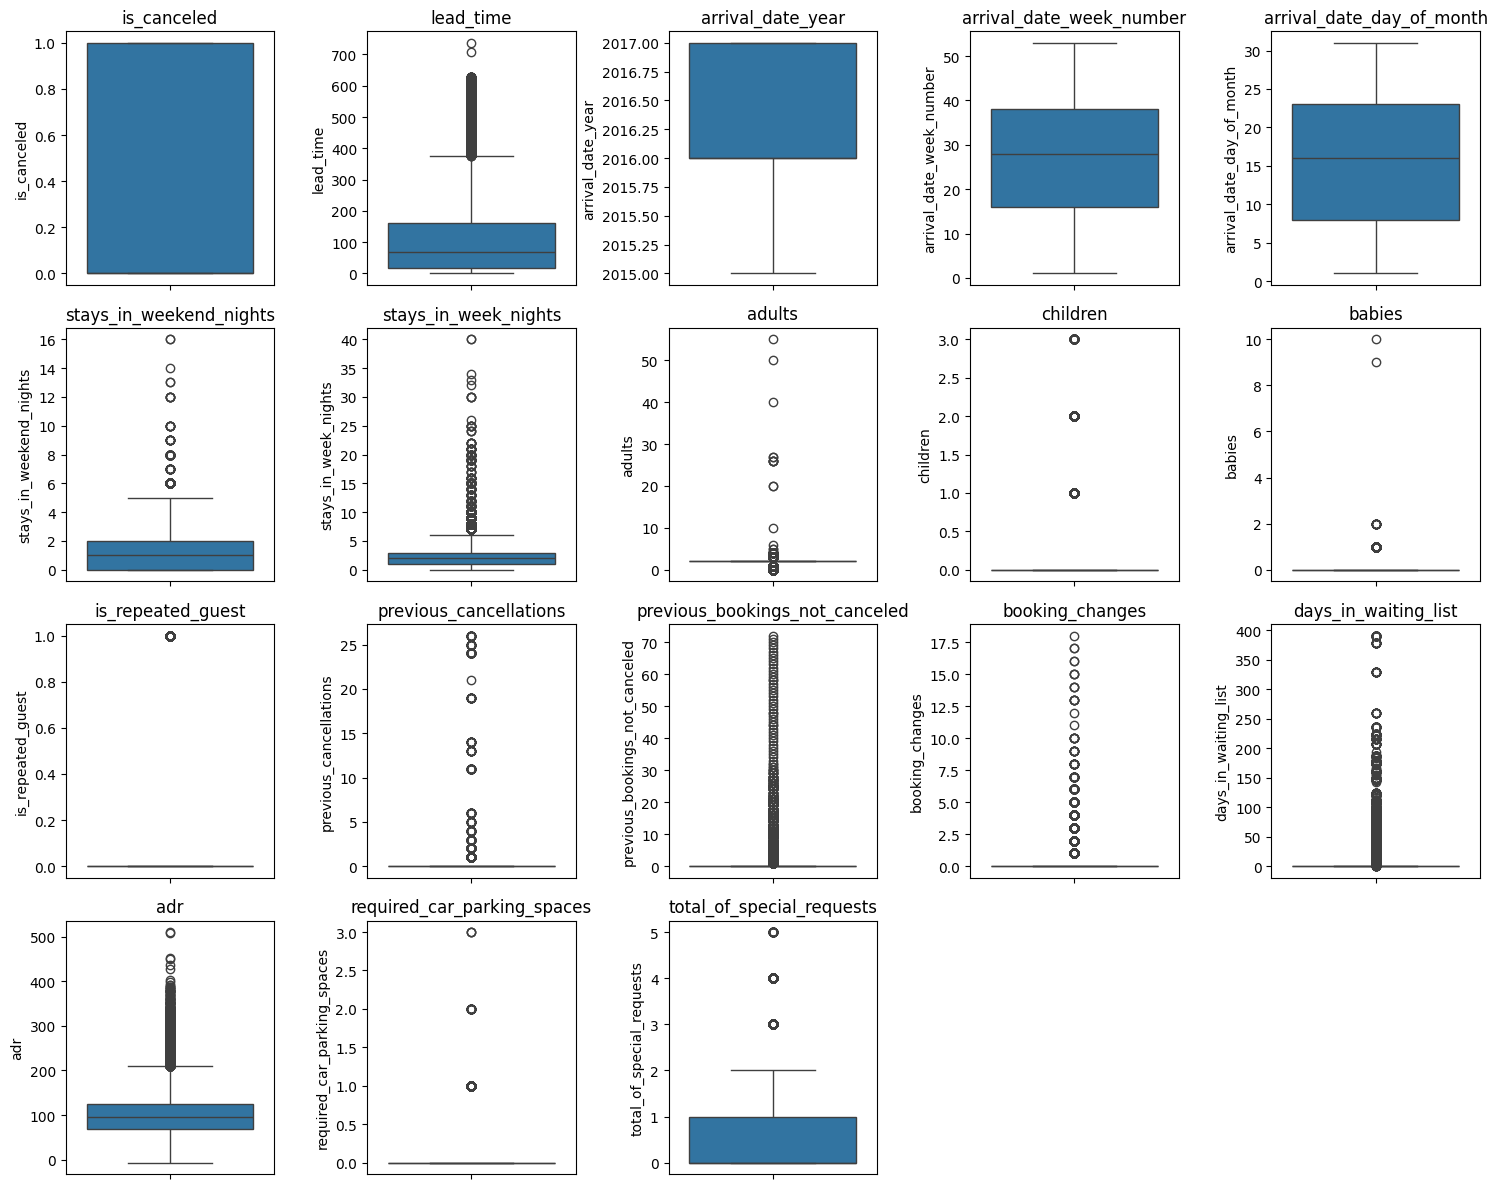

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

l = 0
for i in range(4):
    for j in range(5):
        if l < len(num_data):
            sns.boxplot(df[num_data[l]], ax=axes[i, j])
            axes[i, j].set_title(num_data[l])
            l += 1
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

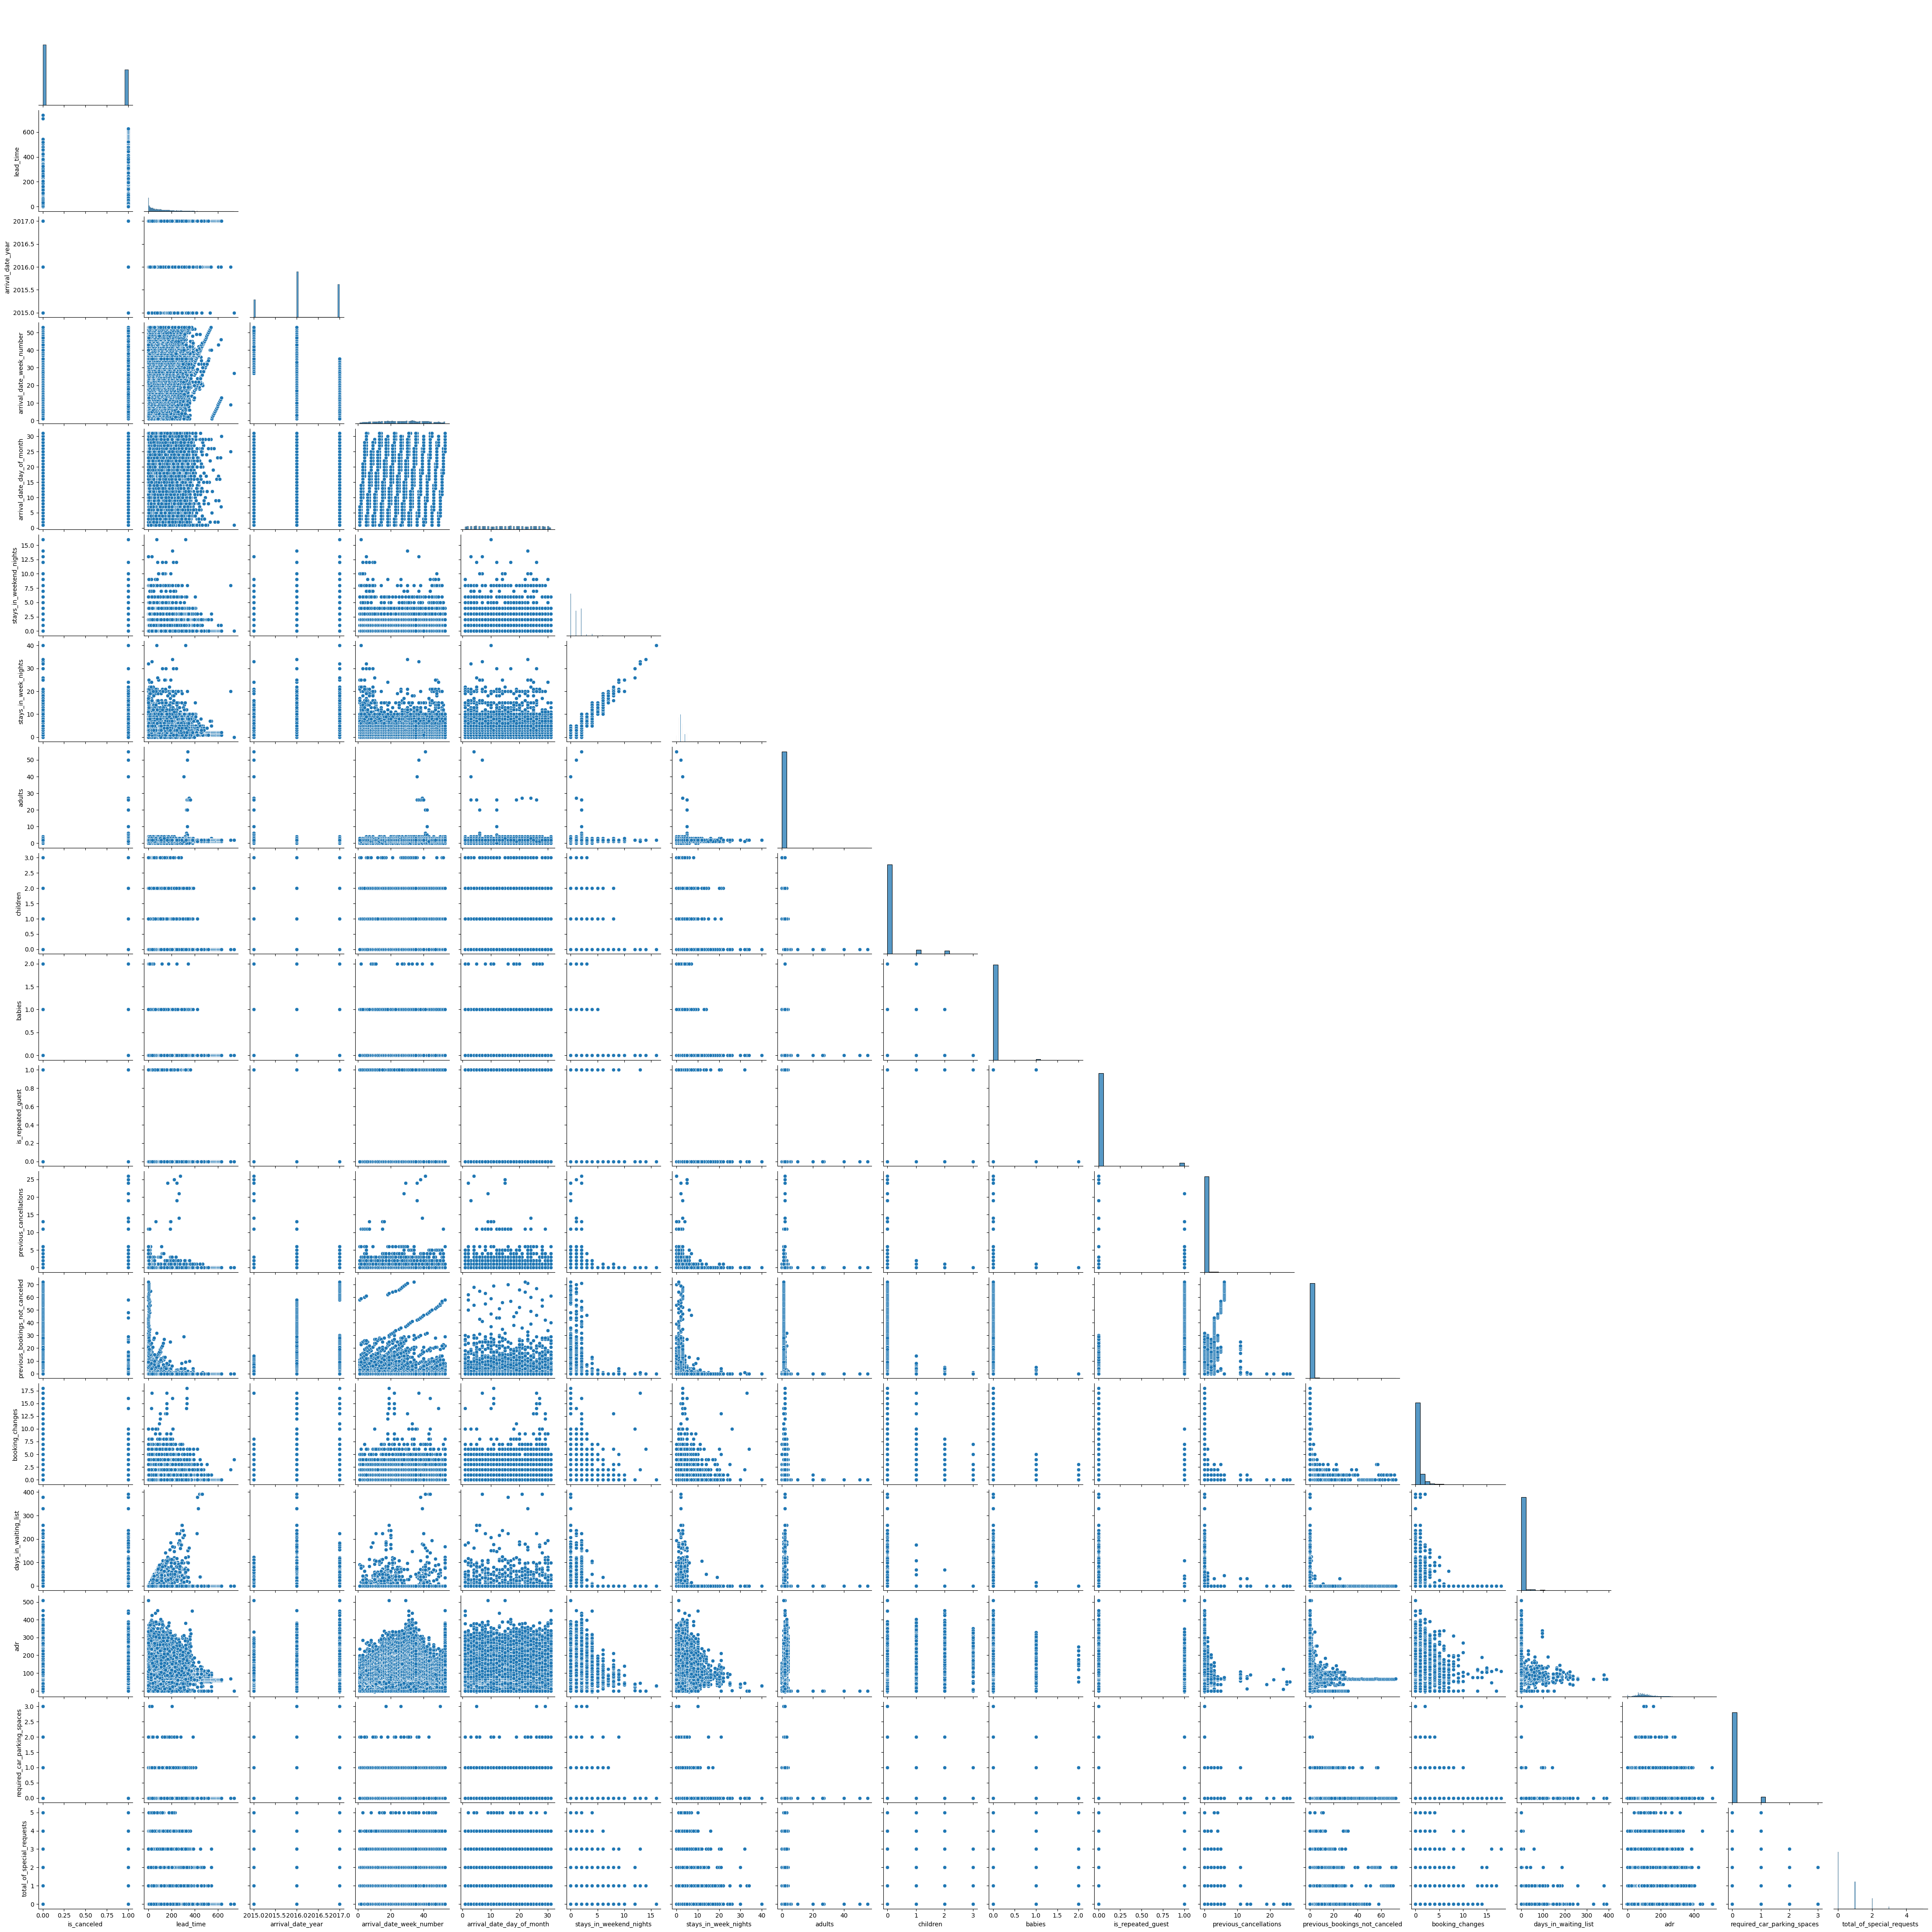

In [ ]:
sns.pairplot(df,corner=True)

In [ ]:
#Removing outlier from adr
df=df[df['adr']<5000]

In [ ]:
#Removing outlier from children
df=df[df['children']<8]

In [ ]:
#Removing outlier from required_car_parking_spaces
df=df[df['required_car_parking_spaces']<7]

In [ ]:
df[df['is_repeated_guest']==0]['is_canceled'].value_counts()

is_canceled
0    71388
1    43588
Name: count, dtype: int64

In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
# number of cancelletion monthly
df.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
51289,City Hotel,0,133,2016,May,21,17,0,3,2,...,B,1,No Deposit,0,Transient-Party,105.30,0,0,Check-Out,2016-05-20
89362,City Hotel,0,1,2017,January,1,7,0,1,1,...,A,0,No Deposit,0,Transient,65.00,0,3,Check-Out,2017-01-08
29161,Resort Hotel,0,30,2016,October,42,15,2,5,2,...,G,0,No Deposit,0,Transient,146.71,1,0,Check-Out,2016-10-22
20839,Resort Hotel,0,6,2016,February,7,10,0,1,1,...,D,0,No Deposit,0,Transient,34.40,0,0,Check-Out,2016-02-11
36266,Resort Hotel,0,156,2017,May,19,8,2,5,2,...,D,0,No Deposit,0,Transient-Party,92.00,0,0,Check-Out,2017-05-15


Text(0.5, 1.0, 'Non-Cancelletion monthly')

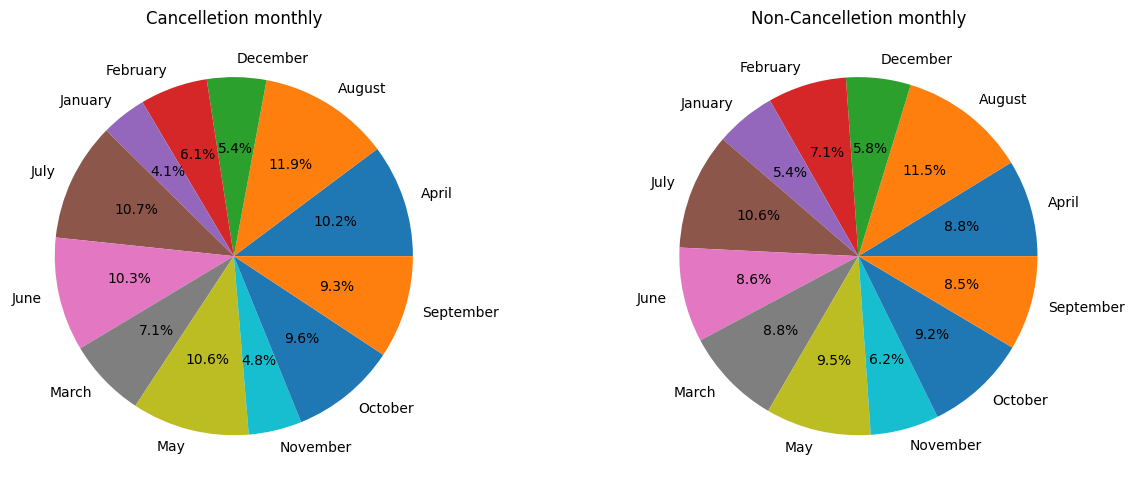

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
name1=df.groupby(['is_canceled','arrival_date_month']).size()[1].index
val1=df.groupby(['is_canceled','arrival_date_month']).size()[1].values
plt.pie(val1,labels=name1,autopct='%1.1f%%')
plt.tight_layout()
plt.title('Cancelletion monthly')
plt.subplot(122)
name2=df.groupby(['is_canceled','arrival_date_month']).size()[0].index
val2=df.groupby(['is_canceled','arrival_date_month']).size()[0].values
plt.pie(val2,labels=name2,autopct='%1.1f%%')
plt.tight_layout()
plt.title('Non-Cancelletion monthly')

FINDING ALL VALUE GREATER THAN 75% FOR EACH COLUMN


In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'members'],
      dtype='object')

In [ ]:
#cancelation rate check by total memebers
df['members']=df['adults']+df['children']+df['babies']

Text(0.5, 1.0, 'For members greator then 5')

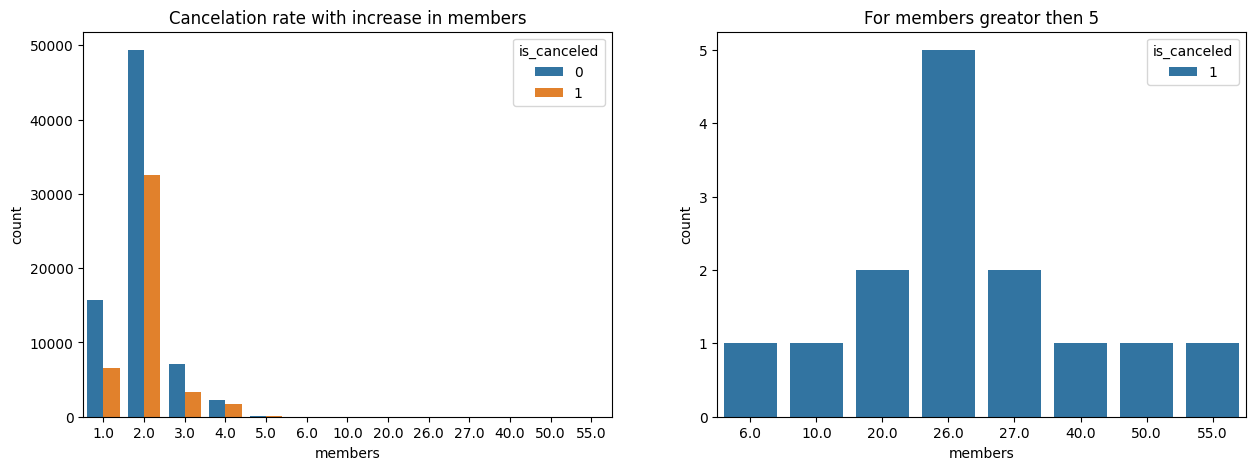

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.countplot(data=df, x='members',hue='is_canceled')
plt.title('Cancelation rate with increase in members')
plt.subplot(122)
sns.countplot(data=df[df['members']>5], x='members',hue='is_canceled')
plt.title('For members greator then 5')

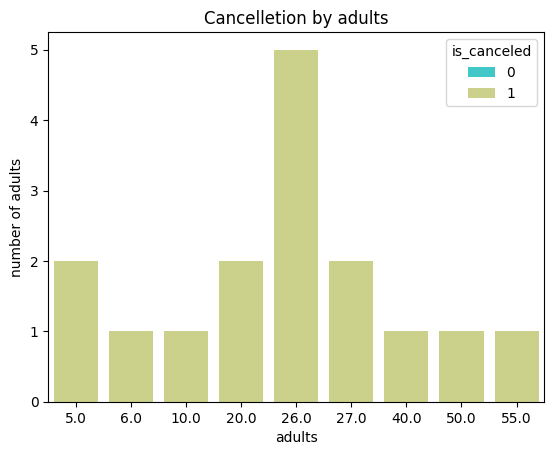

In [ ]:
#for all adults greater than 4 are cancelling
sns.countplot(data=df, x=df[df['adults']>4]['adults'], hue='is_canceled',palette='rainbow')
plt.ylabel('number of adults')
plt.title('Cancelletion by adults')
plt.show()

Insights

1.All bookings were cancelled where members greator then 5 majorly this is due to adults

In [ ]:
#Removing Outlier from babies column
df=df[df['babies']<8]

**REPEATED GUEST ANALYSIS**

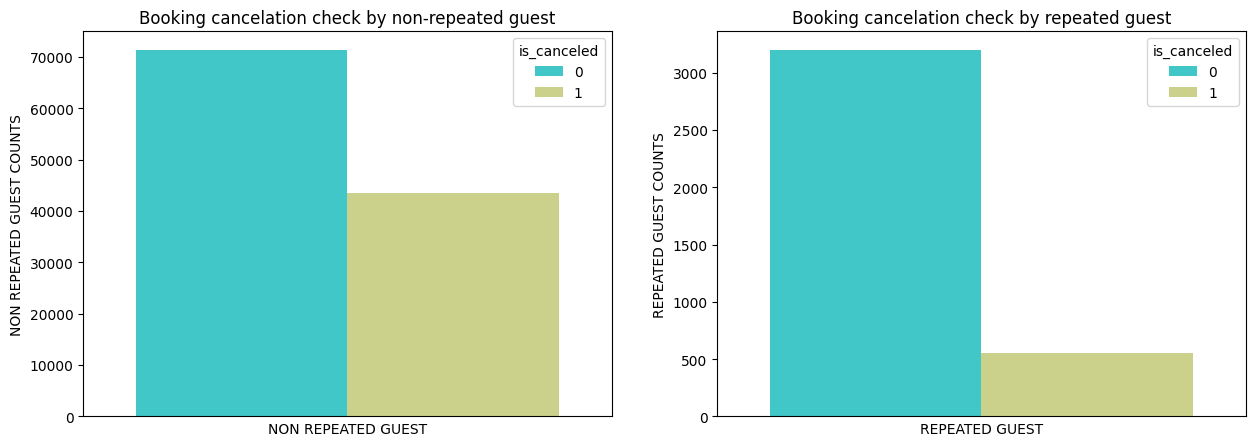

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=df[df['is_repeated_guest']==0]['is_repeated_guest'],data=df,hue='is_canceled',palette='rainbow',ax=axs[0])
sns.countplot(x=df[df['is_repeated_guest']==1]['is_repeated_guest'],data=df,hue='is_canceled',palette='rainbow',ax=axs[1] )
axs[0].set_xlabel('NON REPEATED GUEST')
axs[0].set_ylabel('NON REPEATED GUEST COUNTS')
axs[0].set_title(f'Booking cancelation check by non-repeated guest')
axs[0].set_xticks([])


axs[1].set_xlabel('REPEATED GUEST')
axs[1].set_ylabel('REPEATED GUEST COUNTS')
axs[1].set_title(f'Booking cancelation check by repeated guest')
axs[1].set_xticks([])
plt.show()

Insights

1.Repeated guest make very less booking cancelation then non repeated guest

In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'total_of_special_requests', 'reservation_status',
       'reservation_status_date', 'name', 'email', 'phone-number',
       'credit_card'],
      dtype='object')

Comparing repeated guest with previous cancelation

In [ ]:
#Guest who previously cancelled
guest_cancel=df[df['previous_cancellations']>0]
data2=guest_cancel.groupby(['is_repeated_guest','is_canceled'])[['previous_cancellations']].sum()
data2 = data2.reset_index()
data2['is_repeated_guest'] = data2['is_repeated_guest'].map({1: 'repeated_guest', 0: 'non-repeated_guest'})
data2['is_canceled'] = data2['is_canceled'].map({1: 'canceled', 0: 'not_canceled'})

In [ ]:
#Guest who will not previously canceled
guest_notcancel=df[df['previous_cancellations']==0]

data3=guest_notcancel.groupby(['is_repeated_guest','is_canceled'])[['previous_cancellations']].value_counts()

data3 = data3.reset_index()

data3 = data3.drop('previous_cancellations', axis=1)
data3['is_repeated_guest'] = data3['is_repeated_guest'].map({1: 'repeated_guest', 0: 'non-repeated_guest'})
data3['is_canceled'] = data3['is_canceled'].map({1: 'canceled', 0: 'not_canceled'})

Text(0.5, 1.0, 'Cancellation Check of previously not  canceled guest')

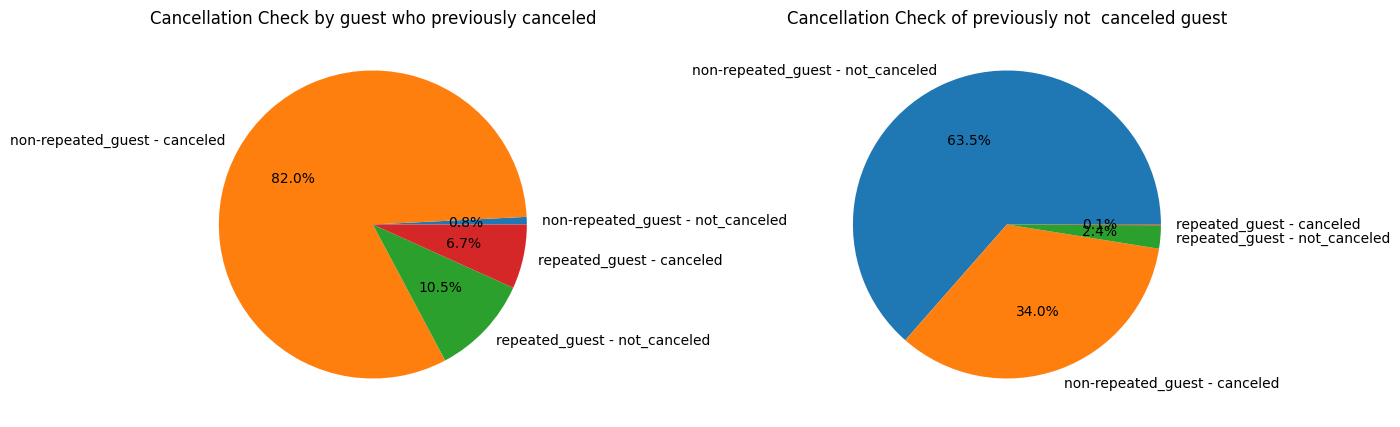

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
x_values = (data2['is_repeated_guest'] + ' - ' + data2['is_canceled']).tolist()
y_values = data2['previous_cancellations'].values

plt.pie(y_values, labels=x_values, autopct='%1.1f%%')
plt.title('Cancellation Check by guest who previously canceled')
plt.subplot(122)
x_values = (data3['is_repeated_guest'] + ' - ' + data3['is_canceled']).tolist()
y_values = data3['count'].values

plt.pie(y_values, labels=x_values, autopct='%1.1f%%')
plt.title('Cancellation Check for previously booked but not canceled guest')

Insights

 ->In a previously canceled data

  1.Non repetitive guest canceled more then repetitive guest

  ->In a non previously canceled data

  1.Non repetitive guest canceled very less then canceled data

Text(0.5, 1.0, 'Hotel Wise repeated guest Check')

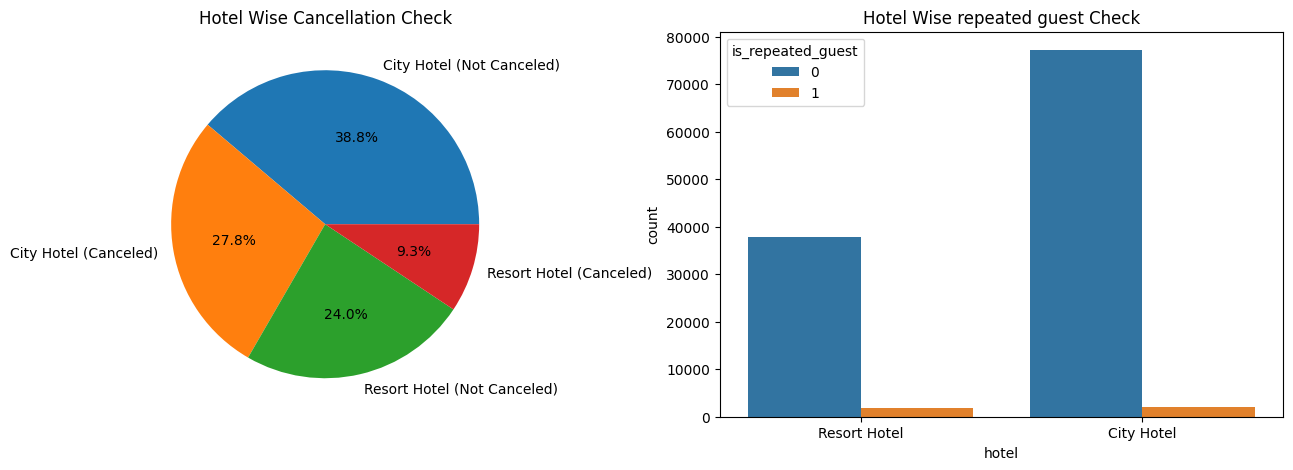

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(16,5))
plt.subplot(121)
name4 = df.groupby(['hotel','is_canceled']).size().index
val4 = df.groupby(['hotel','is_canceled']).size().values


new_labels = []
for label in name4:
    hotel, is_canceled = label
    new_label = f"{hotel} ({'Canceled' if is_canceled == 1 else 'Not Canceled'})"
    new_labels.append(new_label)

plt.pie(val4, labels=new_labels, autopct='%1.1f%%')
plt.title('Hotel Wise Cancellation Check')
plt.subplot(122)
sns.countplot(data=df,x='hotel',hue='is_repeated_guest')
plt.title('Hotel Wise repeated guest Check')

Insights

1.In a city hotel cancellation occur more then resort hotel

2.In both hotel most of the customer are non repetitive

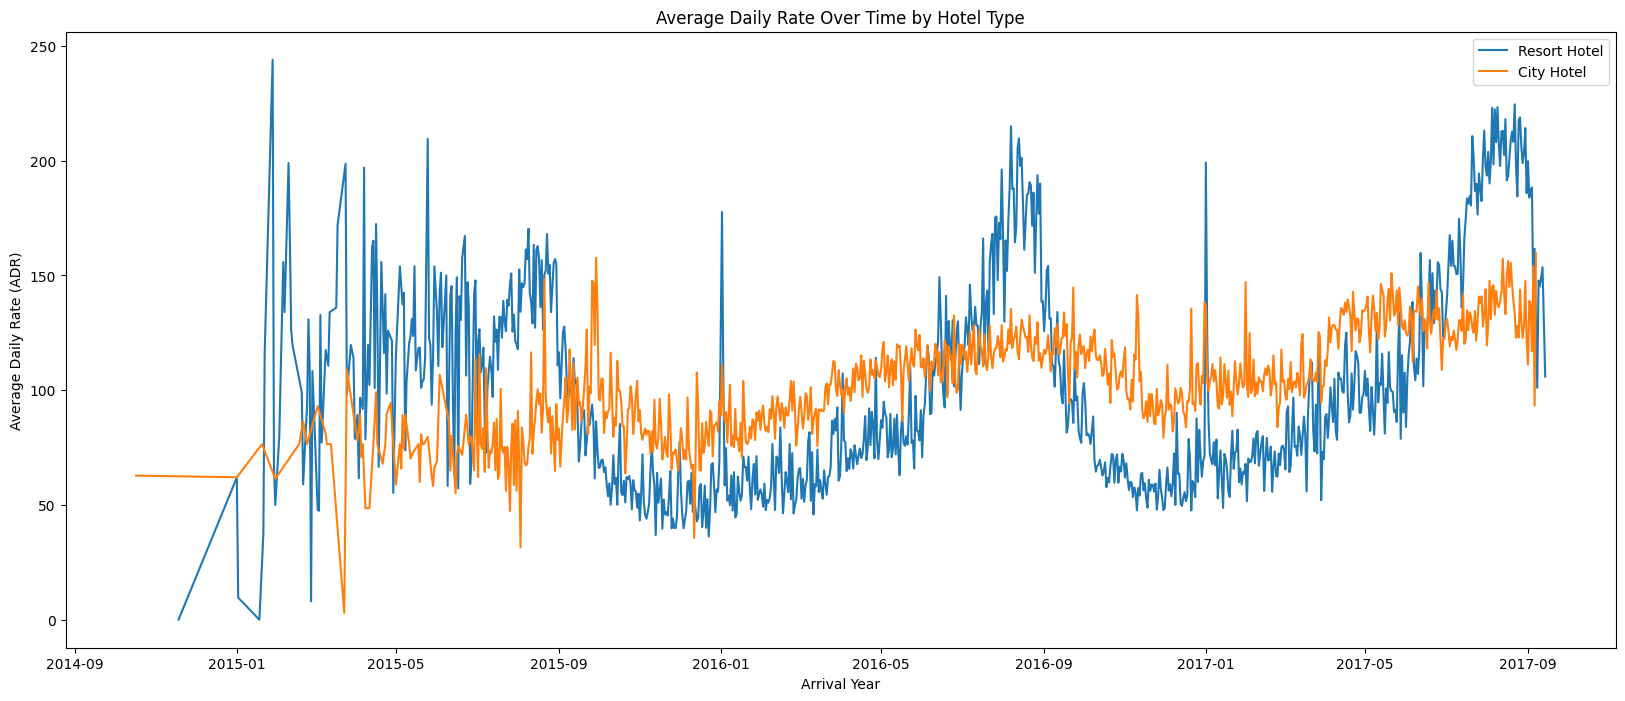

In [ ]:
plt.figure(figsize=(20,8))

#Observe average daily rate with repect to each hotel
resort_data = df[df['hotel']=='Resort Hotel'].groupby('reservation_status_date')['adr'].mean()
plt.plot(resort_data.index, resort_data.values, label='Resort Hotel')

city_data = df[df['hotel']=='City Hotel'].groupby('reservation_status_date')['adr'].mean()
plt.plot(city_data.index, city_data.values, label='City Hotel')

plt.xlabel('Arrival Year')
plt.ylabel('Average Daily Rate (ADR)')
plt.title('Average Daily Rate Over Time by Hotel Type')
plt.legend()
plt.show()

**Observation**

1.City hotel price is comparetively lower than Resort hotel price

2.For some days this adr(Average daily rate) changed specially in weekend

3.As we see up spikes in data for a weekend days

RESORT HOTEL ANALYSIS


In [ ]:
df.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
9512,Resort Hotel,1,24,2017,August,35,31,0,1,2,...,A,0,No Deposit,0,Transient-Party,202.0,0,4,No-Show,2017-08-31
70837,City Hotel,0,26,2017,March,13,26,2,0,2,...,A,0,No Deposit,0,Transient,113.0,0,2,Check-Out,2017-03-28
77463,City Hotel,0,117,2017,July,31,30,2,0,2,...,A,0,No Deposit,0,Transient,80.1,0,0,Check-Out,2017-08-01
28529,Resort Hotel,0,31,2017,May,21,24,0,3,2,...,A,0,No Deposit,0,Transient,90.0,0,2,Check-Out,2017-05-27
11875,Resort Hotel,0,1,2015,September,37,11,0,1,2,...,C,0,No Deposit,0,Transient,131.0,0,0,Check-Out,2015-09-12


In [ ]:
df['month']=df['reservation_status_date'].dt.month

<ipython-input-438-c8c59cc2b4a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month']=df['reservation_status_date'].dt.month


In [ ]:
monthly_canceled=df[df['is_canceled']==1].groupby('month')[['adr']].mean().sort_values('adr')

In [ ]:
monthly_canceled

,adr
month,
10,79.924866
12,90.728232
11,92.070648
1,94.273572
2,103.008688
9,103.190188
7,110.402159
3,111.339769
8,121.427453


<ipython-input-86-bfb910637d14>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month',y='adr',data=monthly_canceled,palette='bright')


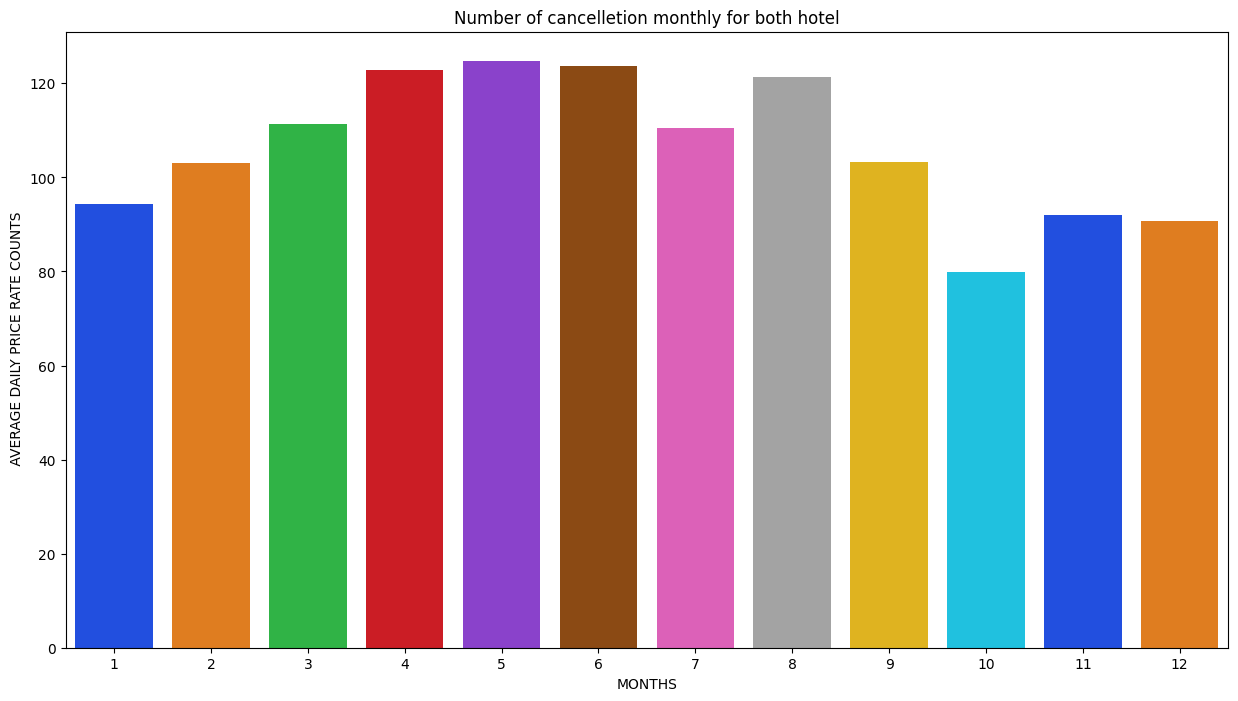

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x='month',y='adr',data=monthly_canceled,palette='bright')
plt.xlabel('MONTHS')
plt.ylabel(' AVERAGE DAILY PRICE RATE COUNTS')
plt.title('Number of cancelletion monthly for both hotel')
plt.show()

**OBSERVATION**

1.Most of cancelation occur in summer season due to high price

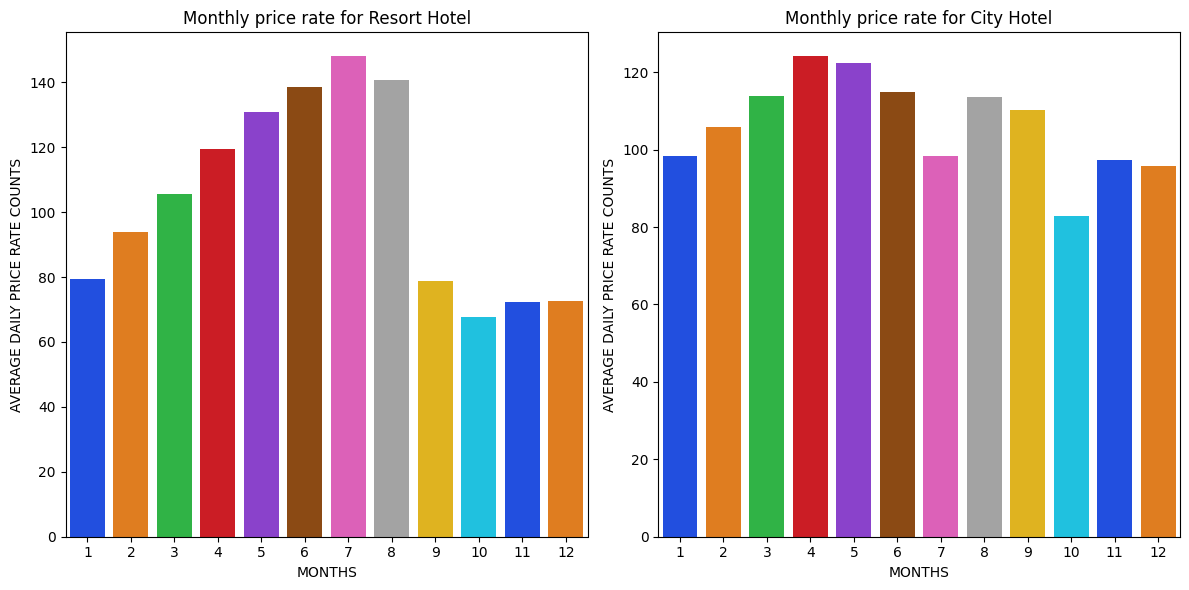

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create figure and axes outside the loop

for i, val in enumerate(df['hotel'].unique()):
    df3 = df[df['hotel'] == val]
    hotel_type = df3[df3['is_canceled'] == 1].groupby('month')[['adr']].mean().sort_values('adr')

    # Assign 'month' to 'hue' and set legend=False
    sns.barplot(x='month', y='adr', data=hotel_type, hue='month', palette='bright', legend=False, ax=axs[i])

    axs[i].set_xlabel('MONTHS')
    axs[i].set_ylabel('AVERAGE DAILY PRICE RATE COUNTS')
    axs[i].set_title(f'Monthly price rate for {val}')

plt.tight_layout()
plt.show()

In [ ]:
df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,0,No Deposit,NaN,NaN,0,Transient,107.0,0,0,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,0,No Deposit,303.0,NaN,0,Transient,103.0,0,1,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,0,No Deposit,240.0,NaN,0,Transient,82.0,0,1,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,0,No Deposit,15.0,NaN,0,Transient,105.5,0,0,2015-04-22


In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'meal', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'total_of_special_requests'],
      dtype='object')

#Unique value identify

In [ ]:
#Unique value for each column
for col in df[categ_data]:
    print(col,':',df[col].unique())
    print("-"*50)

hotel : ['Resort Hotel' 'City Hotel']
--------------------------------------------------
arrival_date_month : ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
--------------------------------------------------
meal : ['BB' 'FB' 'HB' 'SC' 'Undefined']
--------------------------------------------------
country : ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'NOR' 'OMN' 'ARG' 'POL' 'DEU'
 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST' 'CZE'
 'ROU' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'ZAF' 'AGO' 'ISR'
 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM' 'HRV'
 'HKG' 'IRN' 'GEO' 'AND' 'TUR' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PHL' 'SEN' 'SYC' 'AZE' 'LBN'
 'BHR' 'NZL' 'IDN' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB' 'CMR'
 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 

#**Predictive modeling**

#**Perform undersampling of majority class**

In [ ]:
data=df

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
smt=RandomOverSampler()

In [ ]:
data['is_canceled'].value_counts()

is_canceled
0    67285
1    44136
Name: count, dtype: int64

In [ ]:
df.drop(['reserved_room_type','arrival_date_year','meal','reservation_status_date','market_segment','arrival_date_week_number','arrival_date_day_of_month'],axis=1,inplace=True)

<ipython-input-439-55751981c685>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['reserved_room_type','arrival_date_year','meal','reservation_status_date','market_segment','arrival_date_week_number','arrival_date_day_of_month'],axis=1,inplace=True)


In [ ]:
not_canceled=df[df['is_canceled']==0]

In [ ]:
not_canceled.duplicated().value_counts()

False    55391
True     11896
Name: count, dtype: int64

In [ ]:
not_canceled.drop_duplicates(keep='last',inplace=True,ignore_index=True)

<ipython-input-300-caabb34fa133>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_canceled.drop_duplicates(keep='last',inplace=True,ignore_index=True)


In [ ]:
canceled_data=df[df['is_canceled']==1]

In [ ]:
# Shuffle the dataframes
df1_shuffled = not_canceled.sample(frac=1)
df2_shuffled = canceled_data.sample(frac=1)

# Concatenate the shuffled dataframes
data = pd.concat([df1_shuffled, df2_shuffled])

In [ ]:
#Undersampling of majority class
df[df['is_canceled']==0].duplicated().value_counts(),df[df['is_canceled']==1].duplicated().value_counts()

(False    55391
 True     11896
 Name: count, dtype: int64,
 False    23702
 True     20435
 Name: count, dtype: int64)

In [ ]:
data[data['is_canceled']==0].duplicated().value_counts(),data[data['is_canceled']==1].duplicated().value_counts()

(False    55391
 Name: count, dtype: int64,
 False    23702
 True     20435
 Name: count, dtype: int64)

In [ ]:
print("shape before sampling:-",df.shape)
print("shape after sampling:-",data.shape)

shape before sampling:- (111421, 22)
shape after sampling:- (97538, 22)


In [ ]:
#Encoding a dataset
for col in data.columns:
  if data[col].dtype=='object':
    data[col]=data[col].astype('category')
    data[col]=data[col].cat.codes

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold,learning_curve
from sklearn.metrics import classification_report, confusion_matrix

X = data.drop('is_canceled', axis=1)
y = data['is_canceled']
# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Arrays to store evaluation metrics for each fold
confusion_matrices = []
classification_reports = []

# Stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train,y_train=smt.fit_resample(X_train,y_train)
  # Train the Random Forest model with balanced class weights
    rf = RandomForestClassifier(n_estimators=100, random_state=42,criterion='gini',class_weight='balanced')
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Store evaluation metrics
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Extract metrics and calculate the average
precision_list = []
recall_list = []
f1_score_list = []
support_list = []

for report in classification_reports:
    precision_list.append({k: v['precision'] for k, v in report.items() if k not in ('accuracy', 'macro avg', 'weighted avg')})
    recall_list.append({k: v['recall'] for k, v in report.items() if k not in ('accuracy', 'macro avg', 'weighted avg')})
    f1_score_list.append({k: v['f1-score'] for k, v in report.items() if k not in ('accuracy', 'macro avg', 'weighted avg')})
    support_list.append({k: v['support'] for k, v in report.items() if k not in ('accuracy', 'macro avg', 'weighted avg')})

precision_df = pd.DataFrame(precision_list)
recall_df = pd.DataFrame(recall_list)
f1_score_df = pd.DataFrame(f1_score_list)
support_df = pd.DataFrame(support_list)

average_precision = precision_df.mean()
average_recall = recall_df.mean()
average_f1_score = f1_score_df.mean()
average_support = support_df.mean()

# Combine the averages into a single DataFrame for easier viewing
average_report = pd.DataFrame({
    'precision': average_precision,
    'recall': average_recall,
    'f1-score': average_f1_score,
    'support': average_support
})

# Print the average classification report
print('Average Classification Report:')
print(average_report)

Average Classification Report:
   precision    recall  f1-score  support
0   0.999985  1.000000  0.999993  13457.0
1   1.000000  0.999977  0.999989   8827.2


In [ ]:
recall_list

[{'0': 1.0, '1': 1.0},
 {'0': 1.0, '1': 1.0},
 {'0': 1.0, '1': 1.0},
 {'0': 1.0, '1': 1.0},
 {'0': 1.0, '1': 1.0}]

<Axes: >

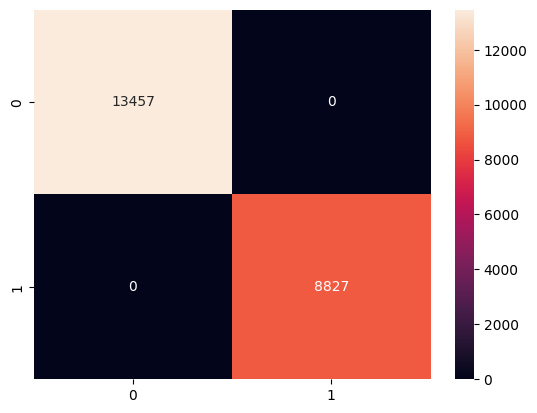

In [ ]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')

In [ ]:
confusion_matrices

[array([[13458,     0],
        [    0,  8827]]),
 array([[13458,     0],
        [    0,  8827]]),
 array([[13457,     0],
        [    0,  8828]]),
 array([[13457,     0],
        [    0,  8828]]),
 array([[13457,     0],
        [    0,  8827]])]

In [ ]:
data[data['is_canceled']==1].sample(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
71332,0,1,343,2017,5,2,2,2,0.0,0,...,0,0,0,0,0,2,89.10,0,0,0
69782,0,1,342,2017,6,0,2,2,0.0,0,...,0,0,1,0,0,3,90.00,0,1,0
4178,1,1,1,2016,3,0,2,2,1.0,0,...,0,2,0,0,0,2,60.00,0,1,2
4164,1,1,38,2016,3,2,3,3,1.0,0,...,7,7,0,0,0,2,68.80,0,0,0
70162,0,1,39,2017,6,2,2,1,0.0,0,...,0,0,0,0,0,2,104.00,0,1,0
62829,0,1,59,2017,4,1,1,2,0.0,0,...,0,0,0,1,0,2,80.00,0,0,0
72059,0,1,336,2017,5,0,2,2,0.0,0,...,0,0,0,0,0,2,99.90,0,0,0
46944,0,1,15,2016,4,2,4,2,0.0,0,...,1,1,1,0,0,3,77.88,0,0,0
80483,0,1,25,2015,2,0,2,1,0.0,0,...,0,0,0,1,0,2,90.00,0,0,0
64296,0,1,28,2017,7,2,5,2,0.0,0,...,3,3,0,0,0,2,101.51,0,0,0


In [ ]:
data.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
65493,0,1,112,2017,0,0,2,2,0.0,0,...,0,0,0,1,0,2,95.00,0,0,0
109656,0,0,185,2017,0,0,3,2,2.0,0,...,5,5,1,0,0,2,189.00,0,0,1
74071,0,1,314,2015,1,0,2,2,0.0,0,...,0,0,0,1,0,0,62.00,0,0,0
99224,0,0,164,2016,10,2,5,2,0.0,0,...,0,0,0,0,0,2,82.28,0,0,1
118352,0,0,123,2017,1,0,3,2,0.0,0,...,4,4,0,0,0,2,185.00,0,0,1


In [ ]:
# Remove the target variable from the row before prediction
row_to_predict = data.iloc[74071].drop('is_canceled').values

# Reshape the row into a 2D array (required by the predict method)
row_to_predict = row_to_predict.reshape(1, -1)

# Now predict
rf.predict(row_to_predict)[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


1

In [ ]:
X_sample=X_test.sample(100)
X_sample

,hotel,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
79913,0,46,2015,9,0,3,2,0.0,0,0,...,1,1,1,0,0,2,105.50,0,1,1
98010,0,159,2016,11,2,3,2,0.0,0,3,...,0,1,1,0,0,2,87.72,0,1,1
55144,0,73,2016,1,1,1,2,0.0,0,0,...,3,3,0,0,0,2,131.40,0,1,0
44580,0,210,2015,10,1,3,2,0.0,0,2,...,0,0,0,0,0,3,86.00,0,0,0
47104,0,35,2016,3,2,1,2,0.0,0,0,...,0,0,0,0,0,2,69.50,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81621,0,130,2016,0,0,4,2,0.0,0,0,...,0,0,0,1,10,2,100.00,0,0,0
84532,0,12,2016,3,0,1,2,0.0,0,0,...,3,3,0,0,0,3,108.00,0,1,1
75642,0,290,2015,1,1,3,2,0.0,0,0,...,0,0,0,0,0,3,62.00,0,0,0
47267,0,1,2016,3,1,0,2,0.0,0,3,...,0,0,0,0,0,2,79.00,0,0,2


In [ ]:
pr_y=rf.predict(X_sample)

In [ ]:
ind=X_sample.index
ind

Index([ 79913,  98010,  55144,  44580,  47104,  95999,  68588,   2219,  37370,
        35359,  35264,  69792,  25640,  96051,  76663,   6492,  91503,  16532,
        81612,  83990, 113292,  57430,  62063, 119278,  48471,  87102,  47440,
        26431,  76182,  33722,  79118,  32201,  53162,  72215,   1893,  15373,
        73120, 105194,  67250,  51019,  79887,  30033, 115074,   9598,  78928,
       106375, 100635,  70075,   8156,  10520,  91435,  18309,  50143,  34958,
        87251, 103705,  33558,  36846,  57971,  75601,  71437,  89844,  75586,
        93836,  61163,  30398,   2381,  71620,  32874,  66873,  66777,  37806,
        68039, 116888,  18820,  69244, 102831, 102961, 108508,  84664,  89942,
        98901,  90079, 106381,   8795,  10861,  60939,  56672,  55060,  27848,
       100889,  89837, 112284,  55333,  78042,  81621,  84532,  75642,  47267,
        39817],
      dtype='int64')

In [ ]:

orig_y=[]
for val in ind:
  orig_y.append(data.loc[val]['is_canceled'])

In [ ]:
confusion_matrix(orig_y,pr_y)

array([[59,  0],
       [ 0, 41]])

In [ ]:

print('Validation Accuracy : ',

      metrics.accuracy_score(y_test,

                             rf.predict(X_test))*100)

Validation Accuracy :  100.0


In [ ]:
from sklearn import metrics

In [ ]:
Test_data=df.sample(frac=1)

In [ ]:
for col in Test_data.columns:
  if Test_data[col].dtype=='object':
    data[col]=Test_data[col].astype('category')
    data[col]=Test_data[col].cat.codes

In [ ]:
Feat= Test_data.drop('is_canceled', axis=1)
target = Test_data['is_canceled']

In [ ]:
Y_comp=rf.predict(Feat)

In [ ]:
confusion_matrix(target,Y_comp)

array([[67285,     0],
       [    0, 44136]])

In [ ]:
Feat.shape

(111421, 22)

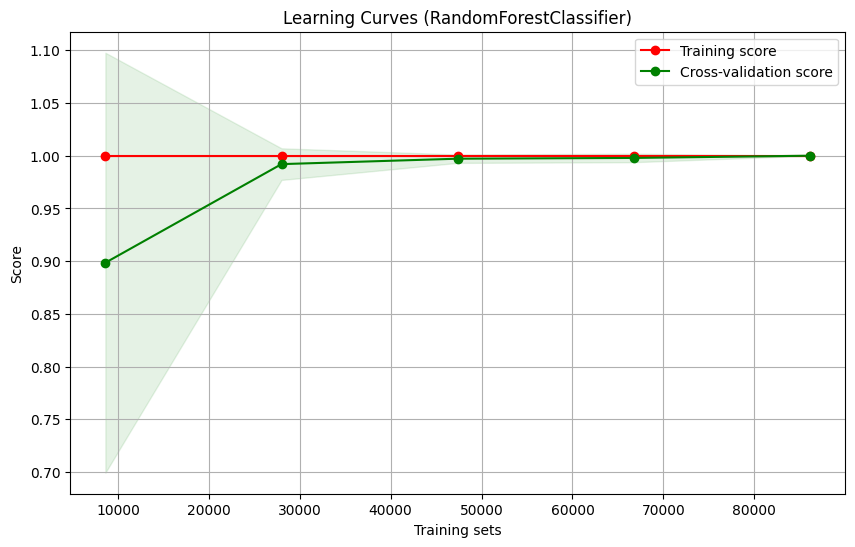

In [ ]:


# Compute learning curves
train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train, cv=5, n_jobs=-1
)

# Calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curves (RandomForestClassifier)')
plt.xlabel('Training sets')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
print("Model score on training data",rf.score(X_train,y_train))
print("Model score on testing data",rf.score(X_test,y_test))

Model score on training data 1.0
Model score on testing data 1.0


In [ ]:

import joblib

# Specify the file path where you want to save the model
model_file = 'Hotel_booking1.pkl'

# Save the model to the specified file
joblib.dump(rf, model_file)

print(f"Model saved to {model_file}")

Model saved to Hotel_booking1.pkl


In [ ]:

import pickle

# Save model using pickle with a lower protocol version
with open('hotel_booking2.pkl', 'wb') as file:
    pickle.dump(rf, file, protocol=2)  # Use protocol=2 or protocol=3

In [ ]:
import gzip
with open('hotel_booking2.pkl', 'rb') as f_in:
    with gzip.open('hotel_booking2.pkl.gz', 'wb') as f_out:
        f_out.writelines(f_in)

array([[0.5       , 0.99670243, 0.99851377, 0.99842088, 0.9986531 ],
       [0.96201003, 0.99981422, 0.99995356, 0.99879244, 0.99944266],
       [0.98978265, 0.99995356, 0.9960522 , 0.99995356, 1.        ],
       [0.98978265, 1.        , 1.        , 0.999582  , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])